# Import

In [73]:
import pandas as pd
import matplotlib.pyplot as plt

import os

In [74]:
SEED = 31827

DATA_PATH = 'data'
DATA_FILE = os.path.join(DATA_PATH, 'Obesity.csv')

# Análise preliminar

In [75]:
df = pd.read_csv(DATA_FILE)

df.head(3)

,Gender,Age,Height,Weight,family_history,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Obesity
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight


## Tratando nomes das colunas

In [76]:
df.columns = [col.lower() for col in df.columns]
df.head(3)

,gender,age,height,weight,family_history,favc,fcvc,ncp,caec,smoke,ch2o,scc,faf,tue,calc,mtrans,obesity
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight


In [77]:
df.dtypes

gender             object
age               float64
height            float64
weight            float64
family_history     object
favc               object
fcvc              float64
ncp               float64
caec               object
smoke              object
ch2o              float64
scc                object
faf               float64
tue               float64
calc               object
mtrans             object
obesity            object
dtype: object

## Tratando os registros

In [78]:
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].str.lower()
        df[col] = df[col].str.strip()

In [79]:
df.head(3)

,gender,age,height,weight,family_history,favc,fcvc,ncp,caec,smoke,ch2o,scc,faf,tue,calc,mtrans,obesity
0,female,21.0,1.62,64.0,yes,no,2.0,3.0,sometimes,no,2.0,no,0.0,1.0,no,public_transportation,normal_weight
1,female,21.0,1.52,56.0,yes,no,3.0,3.0,sometimes,yes,3.0,yes,3.0,0.0,sometimes,public_transportation,normal_weight
2,male,23.0,1.80,77.0,yes,no,2.0,3.0,sometimes,no,2.0,no,2.0,1.0,frequently,public_transportation,normal_weight


## Colunas numéricas
### Decimais

In [80]:
cols_decimal = [
    'age',
    'height'
    ]

for col in cols_decimal:
    df[col] = df[col].astype(float)

In [81]:
df.head(3)

,gender,age,height,weight,family_history,favc,fcvc,ncp,caec,smoke,ch2o,scc,faf,tue,calc,mtrans,obesity
0,female,21.0,1.62,64.0,yes,no,2.0,3.0,sometimes,no,2.0,no,0.0,1.0,no,public_transportation,normal_weight
1,female,21.0,1.52,56.0,yes,no,3.0,3.0,sometimes,yes,3.0,yes,3.0,0.0,sometimes,public_transportation,normal_weight
2,male,23.0,1.80,77.0,yes,no,2.0,3.0,sometimes,no,2.0,no,2.0,1.0,frequently,public_transportation,normal_weight


### Inteiras

In [82]:
cols_int = [
    'fcvc',
    'ncp',
    'ch2o',
    'faf',
    'tue'
]

In [83]:
df[cols_int].describe()

,fcvc,ncp,ch2o,faf,tue
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,2.419043,2.685628,2.008011,1.010298,0.657866
std,0.533927,0.778039,0.612953,0.850592,0.608927
min,1.000000,1.000000,1.000000,0.000000,0.000000
25%,2.000000,2.658738,1.584812,0.124505,0.000000
50%,2.385502,3.000000,2.000000,1.000000,0.625350
75%,3.000000,3.000000,2.477420,1.666678,1.000000
max,3.000000,4.000000,3.000000,3.000000,2.000000


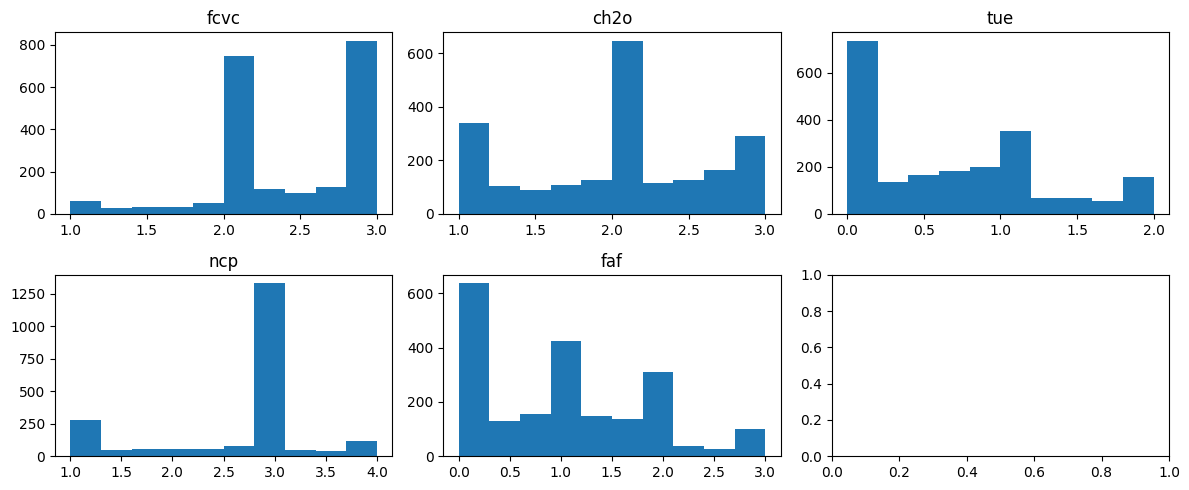

In [84]:
nrows = 2
ncols = 3

fig, axs = plt.subplots(nrows = nrows, ncols = ncols, figsize = (12, 5))

count_row = 0
count_col = 0


for col in cols_int:
    if count_row > nrows - 1:
        count_row = 0
        count_col += 1
    ax = axs[count_row, count_col]
    ax.hist(df[col])
    ax.set_title(col)

    count_row += 1

plt.tight_layout()

Podemos fazer um arredondamento simples.

In [85]:
df[cols_int] = df[cols_int].round()

In [86]:
df.head(3)

,gender,age,height,weight,family_history,favc,fcvc,ncp,caec,smoke,ch2o,scc,faf,tue,calc,mtrans,obesity
0,female,21.0,1.62,64.0,yes,no,2.0,3.0,sometimes,no,2.0,no,0.0,1.0,no,public_transportation,normal_weight
1,female,21.0,1.52,56.0,yes,no,3.0,3.0,sometimes,yes,3.0,yes,3.0,0.0,sometimes,public_transportation,normal_weight
2,male,23.0,1.80,77.0,yes,no,2.0,3.0,sometimes,no,2.0,no,2.0,1.0,frequently,public_transportation,normal_weight


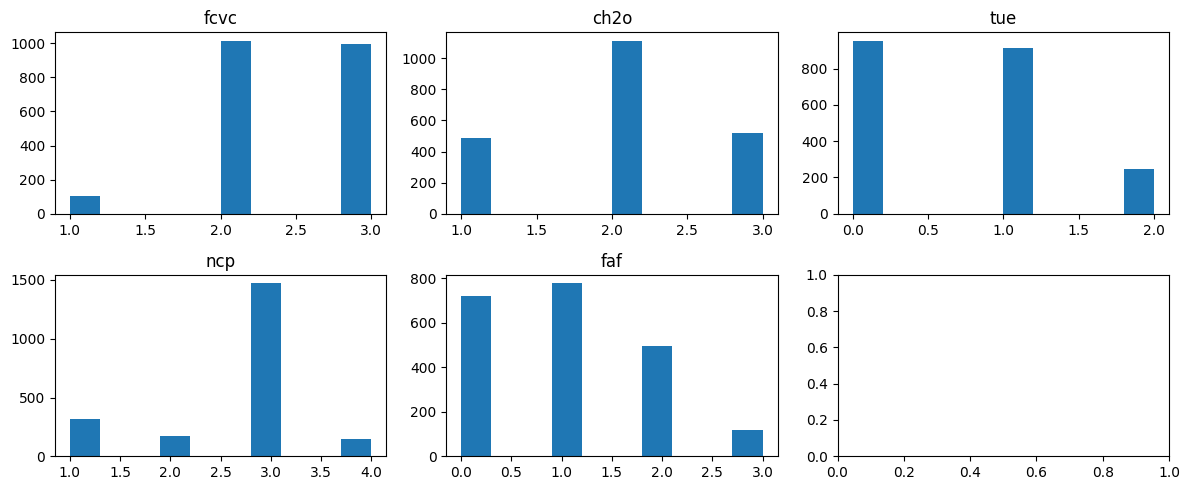

In [87]:
nrows = 2
ncols = 3

fig, axs = plt.subplots(nrows = nrows, ncols = ncols, figsize = (12, 5))

count_row = 0
count_col = 0


for col in cols_int:
    if count_row > nrows - 1:
        count_row = 0
        count_col += 1
    ax = axs[count_row, count_col]
    ax.hist(df[col])
    ax.set_title(col)

    count_row += 1

plt.tight_layout()

## Colunas categóricas

In [88]:
cols_categorical = [
    'gender', 
    'mtrans'
]

## Colunas ordinais

In [89]:
df.caec.unique()

array(['sometimes', 'frequently', 'always', 'no'], dtype=object)

In [90]:
df.calc.unique()

array(['no', 'sometimes', 'frequently', 'always'], dtype=object)

In [91]:
cols_ordinal = {
    'caec':['no', 'sometimes', 'frequently', 'always'],
    'calc':['no', 'sometimes', 'frequently', 'always']
}

## Colunas binárias

In [92]:
cols_binary = [
    'family_history',
    'favc',
    'smoke',
    'scc'
]

dict_yn = {
    'yes': 1,
    'no': 0
}

for col in cols_binary:
    print(df[col].unique())

['yes' 'no']
['no' 'yes']
['no' 'yes']
['no' 'yes']


In [ ]:
# put in the pipeline
# for col in cols_binary:
#     df[col] = df[col].map(dict_yn)

# df.head(3)

,gender,age,height,weight,family_history,favc,fcvc,ncp,caec,smoke,ch2o,scc,faf,tue,calc,mtrans,obesity
0,female,21.0,1.62,64.0,1,0,2.0,3.0,sometimes,0,2.0,0,0.0,1.0,no,public_transportation,normal_weight
1,female,21.0,1.52,56.0,1,0,3.0,3.0,sometimes,1,3.0,1,3.0,0.0,sometimes,public_transportation,normal_weight
2,male,23.0,1.80,77.0,1,0,2.0,3.0,sometimes,0,2.0,0,2.0,1.0,frequently,public_transportation,normal_weight


## Dicionário das colunas
- Age — (Idade) Idade em anos. Valores: numérico contínuo (mín 14, máx 61).
- Height — (Altura) Altura em metros. Valores: numérico contínuo (ex.: 1.45–1.98 m).
- Weight — (Peso) Peso em quilogramas. Valores: numérico contínuo (ex.: 39–173 kg).
- family_history — (Family history of overweight) Histórico familiar de excesso de peso. Valores: yes (há histórico), no (não há).
- FAVC — (Frequent consumption of high-caloric food) Consumo frequente de alimentos muito calóricos. Valores: yes (sim), no (não).
- FCVC — (Frequency of consumption of vegetables) Frequência de consumo de vegetais nas refeições. Valores (escala 1–3): 1 raramente, 2 às vezes, 3
sempre. Nota: no arquivo os valores aparecem com decimais (ruído); interprete arredondando para o inteiro mais próximo.
- NCP — (Number of main meals) Número de refeições principais por dia. Valores (escala 1–4): 1 uma refeição, 2 duas, 3 três, 4 quatro ou mais. Nota: valores com decimais devem ser arredondados.
- CAEC — (Consumption of food between meals) Consumo de lanches/comes entre as refeições. Valores: no (não consome), Sometimes (às vezes), Frequently (frequentemente), Always (sempre).
- SMOKE — (Smoking) Hábito de fumar. Valores: yes (fuma), no (não fuma).
- CH2O — (Daily water consumption) Consumo diário de água. Valores (escala 1–3): 1 < 1 L/dia, 2 1–2 L/dia, 3 > 2 L/dia. Nota: arredonde valores decimais para interpretar a categoria.
- SCC — (Calories consumption monitoring) Monitora a ingestão calórica diária. Valores: yes (sim), no (não).
- FAF — (Physical activity frequency) Frequência semanal de atividade física. Valores (escala 0–3): 0 nenhuma, 1 ~1–2×/sem, 2 ~3–4×/sem, 3 5×/sem ou mais. Nota: arredonde valores decimais.
- TUE — (Time using electronic devices) Tempo diário usando dispositivos eletrônicos. Valores (escala 0–2): 0 ~0–2 h/dia, 1 ~3–5 h/dia, 2 > 5 h/dia.Nota: arredonde valores decimais.
- CALC — (Alcohol consumption) Consumo de bebida alcoólica. Valores: no (não bebe), Sometimes (às vezes), Frequently (frequentemente), Always
(sempre).
- MTRANS — (Transportation used / Mode of transport) Meio de transporte habitual. Valores: Automobile (carro), Motorbike (moto), Bike (bicicleta),
- Public_Transportation (transporte público), Walking (a pé).
- Obesity — (Target label / Nível de obesidade) Classe de peso corporal. Valores: Insufficient_Weight (abaixo do peso), Normal_Weight (peso normal),Overweight_Level_I (sobrepeso I), Overweight_Level_II (sobrepeso II), Obesity_Type_I (obesidade I), Obesity_Type_II (obesidade II),
Obesity_Type_III (obesidade III).